# Task 3 - Cluster Analysis - Location-based Clustering

In this notebook it is all about the location clustering and which pattern we can observe when clustering and plotting it on a map of Chicago.

Getting a deep understanding of how customers use your mobility service is crucial. As an example, for marketing purposes, or managerial decisions. One widely adopted approach to understand customers’ behavior is to find prevalent usage/trip clusters. 

**Tasks:** Based on the taxi trip patterns, can you identify clusters of trip types and/or customer types? How would you label these clusters? 

**Methods:** Identify clusters with soft-clustering and visualize your results. Compare your results to a hard-clustering method of your choice. You can use additional features like “distance to city center”, expressive hourly resolutions (e.g., “bar hours”, “morning commuting”), or even land-use/POI data. 

Furthermore, can you identify spatial hot spots for trip demand using Gaussian Mixture Models (i.e., using Spatial Kernel Density Estimation)?

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering (focus)

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mlp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
#from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
import math
from sklearn.metrics import mean_squared_error
sns.set_theme()

import sklearn
from sklearn.cluster import KMeans
import folium

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
# import datasets
dfChicago = pd.read_csv("..\data\datasets\df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Scaling function

#### Data scaling function:

In [3]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    dfChicago_clu_X_locations_scaled = scaler.fit_transform(df1)
    dfChicago_clu_X_locations_scaled_df = pd.DataFrame(dfChicago_clu_X_locations_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return dfChicago_clu_X_locations_scaled_df



### 2) k-means++ Cluster Functions:

In [4]:
def get_clusters_and_losses(input_data):
    
    clusters_dfChicago_clu_X = []
    losses_dfChicago_clu_X = []

    for k in range(20):
        model_clu_X = KMeans(n_clusters=k+1,n_init=1)
        model_clu_X.fit(input_data)
        clusters_dfChicago_clu_X.append(k+1)
        losses_dfChicago_clu_X.append(model_clu_X.inertia_)
        
    return clusters_dfChicago_clu_X, losses_dfChicago_clu_X

In [5]:
# method to plot the most valuable number of clusters
def plot_best_fitting_number_of_clusters(input_data, title_info):
    
    fig = plt.figure(figsize=(16,8))

    plt.subplot(1, 2, 1)

    clusters, losses = get_clusters_and_losses(input_data)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.title(f"Number of Clusters {title_info}")

    plt.subplot(1, 2, 2)

    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,12])
    plt.title(f"Number of Clusters {title_info} - Deeper Look")

    plt.show()

### 3) Score functions

When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

A lower BIC score for a number of clusters indicates a more suitable and optimal choice of clusters, since it takes into account the complexity of the model and penalizes it for being overly complex (helpful to avoid overfitting).

The silhouette score is defined as measuring the mean distance of each data point to points within a cluster and the nearest neighbour cluster. For the silhouette score a higher value for a specific number of clusters, is a better choice.

Functions for those methods:

#### Silhouette score

In [6]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

#### Bayesian information criterion (BIC)

In [7]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

### 4) Plotting functions:

#### Plot cluster information:

In [8]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

In [9]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

#### Plot scatter with convex hulls:

In [10]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()


### 5) Functions for calculations:

#### Function for quantiles

In [11]:
def get_quantiles_of_clusters(df, n_cluster, cluster_feature):
    
    # create dataframe to store values of calculated quantiles and return df at the end of the method
    dfChicago_quantiles = pd.DataFrame(df)
    # empty all values inside newly created df to just receive columns
    dfChicago_quantiles = dfChicago_quantiles[0:0]

    for cluster in range(0,n_cluster):
        # get 0.25 quantiles
        dict_quantiles_0_25 = df[df[cluster_feature]==cluster].quantile(q=0.25).to_dict()
        # get 0.75 quantiles
        dict_quantiles_0_75 = df[df[cluster_feature]==cluster].quantile(q=0.75).to_dict()
        # round all entries in dictionaries to one decimal place
        dfQuantiles_0_25 = pd.DataFrame(dict_quantiles_0_25, index=[0]).round(2)
        dfQuantiles_0_75 = pd.DataFrame(dict_quantiles_0_75, index=[0]).round(2)
        # parse all values in newly created dfs to strings
        dfQuantiles_0_25 = dfQuantiles_0_25.astype(str)
        dfQuantiles_0_75 = dfQuantiles_0_75.astype(str)
        # combine both quantile dataframes into one interval dataframe
        dfQuantiles_interval = dfQuantiles_0_25 + " - " + dfQuantiles_0_75
        dfQuantiles_interval['Amount Trips in Cluster'] = df[df[cluster_feature]==cluster][cluster_feature].count().astype(int)
        dfQuantiles_interval['Percentage'] = (df[df[cluster_feature]==cluster][cluster_feature].count()/len(df)).round(4)*100
        # concatenate the quantiles row after row
        dfChicago_quantiles = pd.concat([dfChicago_quantiles, dfQuantiles_interval.loc[dfQuantiles_interval.index.values == 0]])
        
    # lastly styling the output dataframe (dropping unnecessary column, resetting the index, giving "Cluster" as index column name)
    dfChicago_quantiles.drop(columns=[cluster_feature], inplace=True)
    dfChicago_quantiles.reset_index(drop=True, inplace=True)
    dfChicago_quantiles = dfChicago_quantiles.rename_axis('Cluster')    
    
    return dfChicago_quantiles

### 6) Functions for mapping clusters on city map

In [12]:
def get_hex_ids_for_cluster_and_resolution(df, cluster_number, resolution):
    # Filter hex IDs for the specified cluster and resolution
    # Group hex IDs by cluster
    grouped_h3_hex_id = df.groupby('cluster_number')[resolution].apply(set).reset_index()
    
    # Get the list of hex IDs for clusters
    hex_ids_for_clusters = grouped_h3_hex_id[grouped_h3_hex_id['cluster_number'] == cluster_number][resolution].iloc[0]
    
    return hex_ids_for_clusters

In [13]:
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

## 3.1 Analysis of Spatial Demand & Clusters

### 3.1.1 Popularity of Community Areas

#### Preparing Data

In [14]:
# dictionary with the names of all community areas in chicago - information retrieved from Wikipedia: https://en.wikipedia.org/wiki/Community_areas_in_Chicago
chicago_community_areas = {
    1: "ROGERS PARK", 2: "WEST RIDGE", 3: "UPTOWN", 4: "LINCOLN SQUARE", 5: "NORTH CENTER", 6: "LAKE VIEW", 7: "LINCOLN PARK", 8: "NEAR NORTH SIDE", 9: "EDISON PARK", 10: "NORWOOD PARK", 
    11: "JEFFERSON PARK", 12: "FOREST GLEN", 13: "NORTH PARK", 14: "ALBANY PARK", 15: "PORTAGE PARK", 16: "IRVING PARK", 17: "DUNNING", 18: "MONTCLARE", 19: "BELMONT CRAGIN", 20: "HERMOSA", 
    21: "AVONDALE", 22: "LOGAN SQUARE", 23: "HUMBOLDT PARK", 24: "WEST TOWN", 25: "AUSTIN", 26: "WEST GARFIELD PARK", 27: "EAST GARFIELD PARK", 28: "NEAR WEST SIDE", 29: "NORTH LAWNDALE", 30: "SOUTH LAWNDALE", 
    31: "LOWER WEST SIDE", 32: "LOOP", 33: "NEAR SOUTH SIDE", 34: "ARMOUR SQUARE", 35: "DOUGLAS", 36: "OAKLAND", 37: "FULLER PARK", 38: "GRAND BOULEVARD", 39: "KENWOOD", 40: "WASHINGTON PARK",
    41: "HYDE PARK", 42: "WOODLAWN", 43: "SOUTH SHORE", 44: "CHATHAM", 45: "AVALON PARK", 46: "SOUTH CHICAGO", 47: "BURNSIDE", 48: "CALUMET HEIGHTS", 49: "ROSELAND", 50: "PULLMAN", 
    51: "SOUTH DEERING", 52: "EAST SIDE", 53: "WEST PULLMAN", 54: "RIVERDALE", 55: "HEGEWISCH", 56: "GARFIELD RIDGE", 57: "ARCHER HEIGHTS", 58: "BRIGHTON PARK", 59: "MCKINLEY PARK", 60: "BRIDGEPORT",
    61: "NEW CITY", 62: "WEST ELSDON", 63: "GAGE PARK", 64: "CLEARING", 65: "WEST LAWN", 66: "CHICAGO LAWN", 67: "WEST ENGLEWOOD", 68: "ENGLEWOOD", 69: "GREATER GRAND CROSSING", 70: "ASHBURN", 
    71: "AUBURN GRESHAM", 72: "BEVERLY", 73: "WASHINGTON HEIGHTS", 74: "MOUNT GREENWOOD", 75: "MORGAN PARK", 76: "OHARE", 77: "EDGEWATER"
}

In [15]:
dfChicago_Community_Areas_Popularity = pd.DataFrame(dfChicago)

# Map community area numbers to names for pickup and dropoff
dfChicago_Community_Areas_Popularity['Pickup_Community_Area_Name'] = dfChicago_Community_Areas_Popularity['Pickup_Community_Area'].map(chicago_community_areas)
dfChicago_Community_Areas_Popularity['Dropoff_Community_Area_Name'] = dfChicago_Community_Areas_Popularity['Dropoff_Community_Area'].map(chicago_community_areas)

dfChicago_Community_Areas_Popularity

Trip_ID  \
0        27ad87f629bf14fa3cb894daad514cdad4736f9c   
1        9a9d9902dfa267b88400a22a2c9f0cf74384b372   
2        5e07d8d10a2314fb71214c71ca3f19beab79652d   
3        6deda34a1a498737aaa64734fa2c09a0bf335f18   
4        faa2c909d0b88f3f54217135c6919a7fdd73a366   
...                                           ...   
8974515  eda096d2b89a8b2b432642ec1e2a1a1fd72c4dd8   
8974516  9bb135881fb88cd37521eddacd3003d6e6642e8f   
8974517  e93c3a7ee7050521d22a6d513b65d94642813a4c   
8974518  cf906408921ec94acfed42add2165ab0f52fe9b7   
8974519  4996a695833096a0a412b77a918f5202554677bb   

                                                   Taxi_ID  \
0        4b38941e0745acdeefe630832a438a59fdaac78640f68a...   
1        1a1189d1e9f4f676bbeaf49903912684b94453576a234f...   
2        0826a2682f598bf0e39aa460479bc87757bd2fcb72c171...   
3        48c42d95f8331cbfbcab8a6d5299dbb654a041f3c2efff...   
4        2e75c09511f6a1e2dee45f65888243ab9093f6c1558f10...   
...                                                    ...   
8974515  0f1b65c1c73b1a8a687054ea0bb175edd243a5d065d7fa...   
8974516  7b1ac8aace3932ce8b4302cc292a88c6d6f0446ea8134c...   
8974517  9a03b73c5ab73cff888abb6ee2eb598352e4168671bd7c...   
8974518  1e3120e8b2c9af9f006e47d546cc8cee6564dd40b15abe...   
8974519  b56d49bc42507f35096478dd9613ed6aa7978739e34a99...   

        Trip_Start_Timestamp   Trip_End_Timestamp  Trip_Seconds  Trip_Miles  \
0        2013-01-01 00:00:00  2013-01-01 00:00:00         900.0         2.7   
1        2013-01-01 00:00:00  2013-01-01 00:00:00         240.0         0.4   
2        2013-01-01 00:00:00  2013-01-01 00:00:00        1920.0         0.6   
3        2013-01-01 00:00:00  2013-01-01 00:00:00         180.0         1.0   
4        2013-01-01 00:00:00  2013-01-01 00:00:00         240.0         0.3   
...                      ...                  ...           ...         ...   
8974515  2013-12-31 23:00:00  2014-01-01 00:00:00         540.0         1.4   
8974516  2013-12-31 23:00:00  2014-01-01 00:00:00        1860.0         5.9   
8974517  2013-12-31 23:00:00  2014-01-01 00:00:00         720.0         2.0   
8974518  2013-12-31 23:00:00  2013-12-31 23:00:00         660.0         3.5   
8974519  2013-12-31 23:00:00  2014-01-01 00:00:00        1320.0         5.9   

         Pickup_Census_Tract  Dropoff_Census_Tract  Pickup_Community_Area  \
0                        NaN                   NaN                   28.0   
1               1.703107e+10          1.703107e+10                    7.0   
2               1.703122e+10          1.703104e+10                   22.0   
3                        NaN                   NaN                   24.0   
4               1.703128e+10          1.703132e+10                   28.0   
...                      ...                   ...                    ...   
8974515         1.703108e+10          1.703184e+10                    8.0   
8974516         1.703108e+10          1.703106e+10                    8.0   
8974517         1.703132e+10          1.703133e+10                   32.0   
8974518         1.703108e+10          1.703184e+10                    8.0   
8974519                  NaN                   NaN                   22.0   

         Dropoff_Community_Area  ...  humidity  temperature_celsius  \
0                           8.0  ...      64.0                -0.19   
1                           7.0  ...      64.0                -0.19   
2                           4.0  ...      64.0                -0.19   
3                          24.0  ...      64.0                -0.19   
4                          32.0  ...      64.0                -0.19   
...                         ...  ...       ...                  ...   
8974515                     8.0  ...      89.0               -11.00   
8974516                     6.0  ...      89.0               -11.00   
8974517                    33.0  ...      89.0               -11.00   
8974518                    33.0  ...      89.0               -11.00   
89745

In [16]:
# Select the relevant columns from the DataFrame
Community_Area_Location = dfChicago_Community_Areas_Popularity[['Pickup_Community_Area_Name', 'Dropoff_Community_Area_Name',
                                                               'Pickup_Census_Tract', 'Dropoff_Census_Tract', 'Pickup_Centroid_Latitude', 
                                                               'Pickup_Centroid_Longitude', 'Dropoff_Centroid_Latitude', 'Dropoff_Centroid_Longitude']]

# Filter the DataFrame to include only rows where both 'Pickup_Census_Tract' and 'Dropoff_Census_Tract' are NaN
filtered_Community_Area_Location = Community_Area_Location[
    pd.isna(Community_Area_Location['Pickup_Census_Tract']) & pd.isna(Community_Area_Location['Dropoff_Census_Tract'])
]

# Group the filtered DataFrame by 'Pickup_Community_Area_Name' and aggregate the latitude and longitude values
grouped_Community_Area_Location = filtered_Community_Area_Location.groupby(['Dropoff_Community_Area_Name']).agg({
    'Dropoff_Centroid_Latitude': 'first',      # Get the first latitude value
    'Dropoff_Centroid_Longitude': 'first'     # Get the first longitude value
}).reset_index()

# Rename the columns
grouped_Community_Area_Location.rename(columns={
    'Dropoff_Community_Area_Name': 'Community_Area_Name',
    'Dropoff_Centroid_Latitude': 'Centroid_Latitude',
    'Dropoff_Centroid_Longitude': 'Centroid_Longitude'
}, inplace=True)

# Display the grouped DataFrame showing unique latitude and longitude values for each community area
grouped_Community_Area_Location


Community_Area_Name  Centroid_Latitude  Centroid_Longitude
0          ALBANY PARK          41.968069          -87.721559
1       ARCHER HEIGHTS          41.810879          -87.726363
2        ARMOUR SQUARE          41.842076          -87.633973
3              ASHBURN          41.745758          -87.708366
4       AUBURN GRESHAM          41.744205          -87.656306
..                 ...                ...                 ...
72           WEST LAWN          41.769778          -87.726930
73        WEST PULLMAN          41.673820          -87.635740
74          WEST RIDGE          42.001571          -87.695013
75           WEST TOWN          41.901207          -87.676356
76            WOODLAWN          41.778877          -87.594925

[77 rows x 3 columns]

In [17]:
# Calculate the total number of rented taxis for pickups
pickup_counts = dfChicago_Community_Areas_Popularity.groupby('Pickup_Community_Area_Name')['Pickup_Community_Area'].count().reset_index(name='numberOfPickups')

# Sort the DataFrame by 'numberOfRentedTaxis' in ascending order
pickups_sorted = pickup_counts.sort_values(by='numberOfPickups', ascending=False)

# Reset the index and clean up the DataFrame
pickups_sorted.reset_index(drop=True, inplace=True)

pickups_sorted

Pickup_Community_Area_Name  numberOfPickups
0             NEAR NORTH SIDE          3026755
1                        LOOP          1839245
2                   LAKE VIEW           896067
3              NEAR WEST SIDE           773855
4                LINCOLN PARK           718362
..                        ...              ...
72               WEST PULLMAN               39
73                  HEGEWISCH               17
74            MOUNT GREENWOOD               15
75                  EAST SIDE               13
76                  RIVERDALE                4

[77 rows x 2 columns]

In [18]:
# Calculate the total number of rented taxis for pickups
dropoff_counts = dfChicago_Community_Areas_Popularity.groupby('Dropoff_Community_Area_Name')['Dropoff_Community_Area'].count().reset_index(name='numberOfDropoffs')

# Sort the DataFrame by 'numberOfRentedTaxis' in ascending order
dropoffs_sorted = dropoff_counts.sort_values(by='numberOfDropoffs', ascending=False)

# Reset the index and clean up the DataFrame
dropoffs_sorted.reset_index(drop=True, inplace=True)

dropoffs_sorted

Dropoff_Community_Area_Name  numberOfDropoffs
0              NEAR NORTH SIDE           2594517
1                         LOOP           1610210
2               NEAR WEST SIDE            887599
3                    LAKE VIEW            858231
4                 LINCOLN PARK            735007
..                         ...               ...
72                WEST PULLMAN                57
73                   EAST SIDE                55
74                    BURNSIDE                52
75                   HEGEWISCH                19
76                   RIVERDALE                 7

[77 rows x 2 columns]

In [19]:
# Merge pickup and dropoff DataFrames
combined_df = pd.merge(dropoff_counts, pickup_counts, left_on='Dropoff_Community_Area_Name', right_on='Pickup_Community_Area_Name', how='outer')

# Fill NaN values with 0 and calculate the combined column
combined_df.fillna(0, inplace=True)
combined_df['Community_Area_Popularity'] = combined_df['numberOfDropoffs'] + combined_df['numberOfPickups']

# Drop 'Pickup_Community_Area_Name' column and rename first column
combined_df.drop(['Pickup_Community_Area_Name'], axis=1, inplace=True)
combined_df.rename(columns={'Dropoff_Community_Area_Name': 'Community_Area_Name'}, inplace=True)

# Sort the DataFrame in descending order based on 'Community_Area_Popularity'
Community_Area_Popularity_Without_Locations = combined_df.sort_values(by='Community_Area_Popularity', ascending=True)

# Reset the index and clean up the DataFrame
Community_Area_Popularity_Without_Locations.reset_index(drop=True, inplace=True)

Community_Area_Popularity_Without_Locations['numberOfPickups'] = Community_Area_Popularity_Without_Locations['numberOfPickups'].astype(int)
Community_Area_Popularity_Without_Locations['Community_Area_Popularity'] = Community_Area_Popularity_Without_Locations['Community_Area_Popularity'].astype(int)

Community_Area_Popularity_Without_Locations


Community_Area_Name  numberOfDropoffs  numberOfPickups  \
0            RIVERDALE                 7                4   
1            HEGEWISCH                19               17   
2            EAST SIDE                55               13   
3         WEST PULLMAN                57               39   
4             BURNSIDE                52               54   
..                 ...               ...              ...   
72        LINCOLN PARK            735007           718362   
73      NEAR WEST SIDE            887599           773855   
74           LAKE VIEW            858231           896067   
75                LOOP           1610210          1839245   
76     NEAR NORTH SIDE           2594517          3026755   

    Community_Area_Popularity  
0                          11  
1                          36  
2                          68  
3                          96  
4                         106  
..                        ...  
72                    1453369  
73                    1661454  
74                    1754298  
75                    3449455  
76                    5621272  

[77 rows x 4 columns]

In [20]:
# Assuming 'Community_Area_Popularity' and 'grouped_Community_Area_Location' are your DataFrames

# Merge the two DataFrames on 'Community_Area_Name'
Community_Area_Popularity = Community_Area_Popularity_Without_Locations.merge(grouped_Community_Area_Location, on='Community_Area_Name', how='left')

# Display the combined DataFrame
Community_Area_Popularity


Community_Area_Name  numberOfDropoffs  numberOfPickups  \
0            RIVERDALE                 7                4   
1            HEGEWISCH                19               17   
2            EAST SIDE                55               13   
3         WEST PULLMAN                57               39   
4             BURNSIDE                52               54   
..                 ...               ...              ...   
72        LINCOLN PARK            735007           718362   
73      NEAR WEST SIDE            887599           773855   
74           LAKE VIEW            858231           896067   
75                LOOP           1610210          1839245   
76     NEAR NORTH SIDE           2594517          3026755   

    Community_Area_Popularity  Centroid_Latitude  Centroid_Longitude  
0                          11          41.660136          -87.602848  
1                          36          41.663671          -87.540936  
2                          68          41.707311          -87.534903  
3                          96          41.673820          -87.635740  
4                         106          41.728182          -87.596476  
..                        ...                ...                 ...  
72                    1453369          41.922686          -87.649489  
73                    1661454          41.874005          -87.663518  
74                    1754298          41.944227          -87.655998  
75                    3449455          41.878866          -87.625192  
76                    5621272          41.899602          -87.633308  

[77 rows x 6 columns]

### 3.1.2 Plot the Data for Least & Most Popular Stations

#### Visualization of Data for the Most Popular Community Areas in Chicago

In [21]:
# prepare dataframe combined_stations for plotting
popularity_stations = pd.DataFrame(Community_Area_Popularity, columns=['Community_Area_Name', 'numberOfDropoffs', 'numberOfPickups', 'Community_Area_Popularity'])

# set index to station name 
popularity_stations.set_index(['Community_Area_Name'], inplace=True)

# Method to Plot the data
def plot_popularity_stations(popularity, x):
    if popularity == 'most popular':
        ax = popularity_stations.tail(x).plot(kind="barh", figsize=(60,40), fontsize=50, width=0.8)
        ax.set_xlabel('Number of rented bikes', fontsize=60)
        ax.set_ylabel('Station names', fontsize = 60)
        # Prevent scientific notation on the x-axis
        plt.ticklabel_format(style='plain', axis='x')
        ax.set_title(label= str(x) + ' Most Popular Community Areas', fontsize = 80)
        ax.legend(fontsize = 40)
    elif popularity == 'least popular':
        ax = popularity_stations.tail(x).plot(kind="barh", figsize=(60,40), fontsize=50, width=0.8)
        ax.set_xlabel('Number of rented bikes', fontsize=60)
        ax.set_ylabel('Station names', fontsize = 60)
        # Prevent scientific notation on the x-axis
        plt.ticklabel_format(style='plain', axis='x')
        ax.set_title(label= str(x) + ' Least Popular Community Areas', fontsize = 80)
        ax.legend(fontsize = 40)
    else:
        ax = 'Please define the popularity with either "most popular" or "least popular".'
    return ax

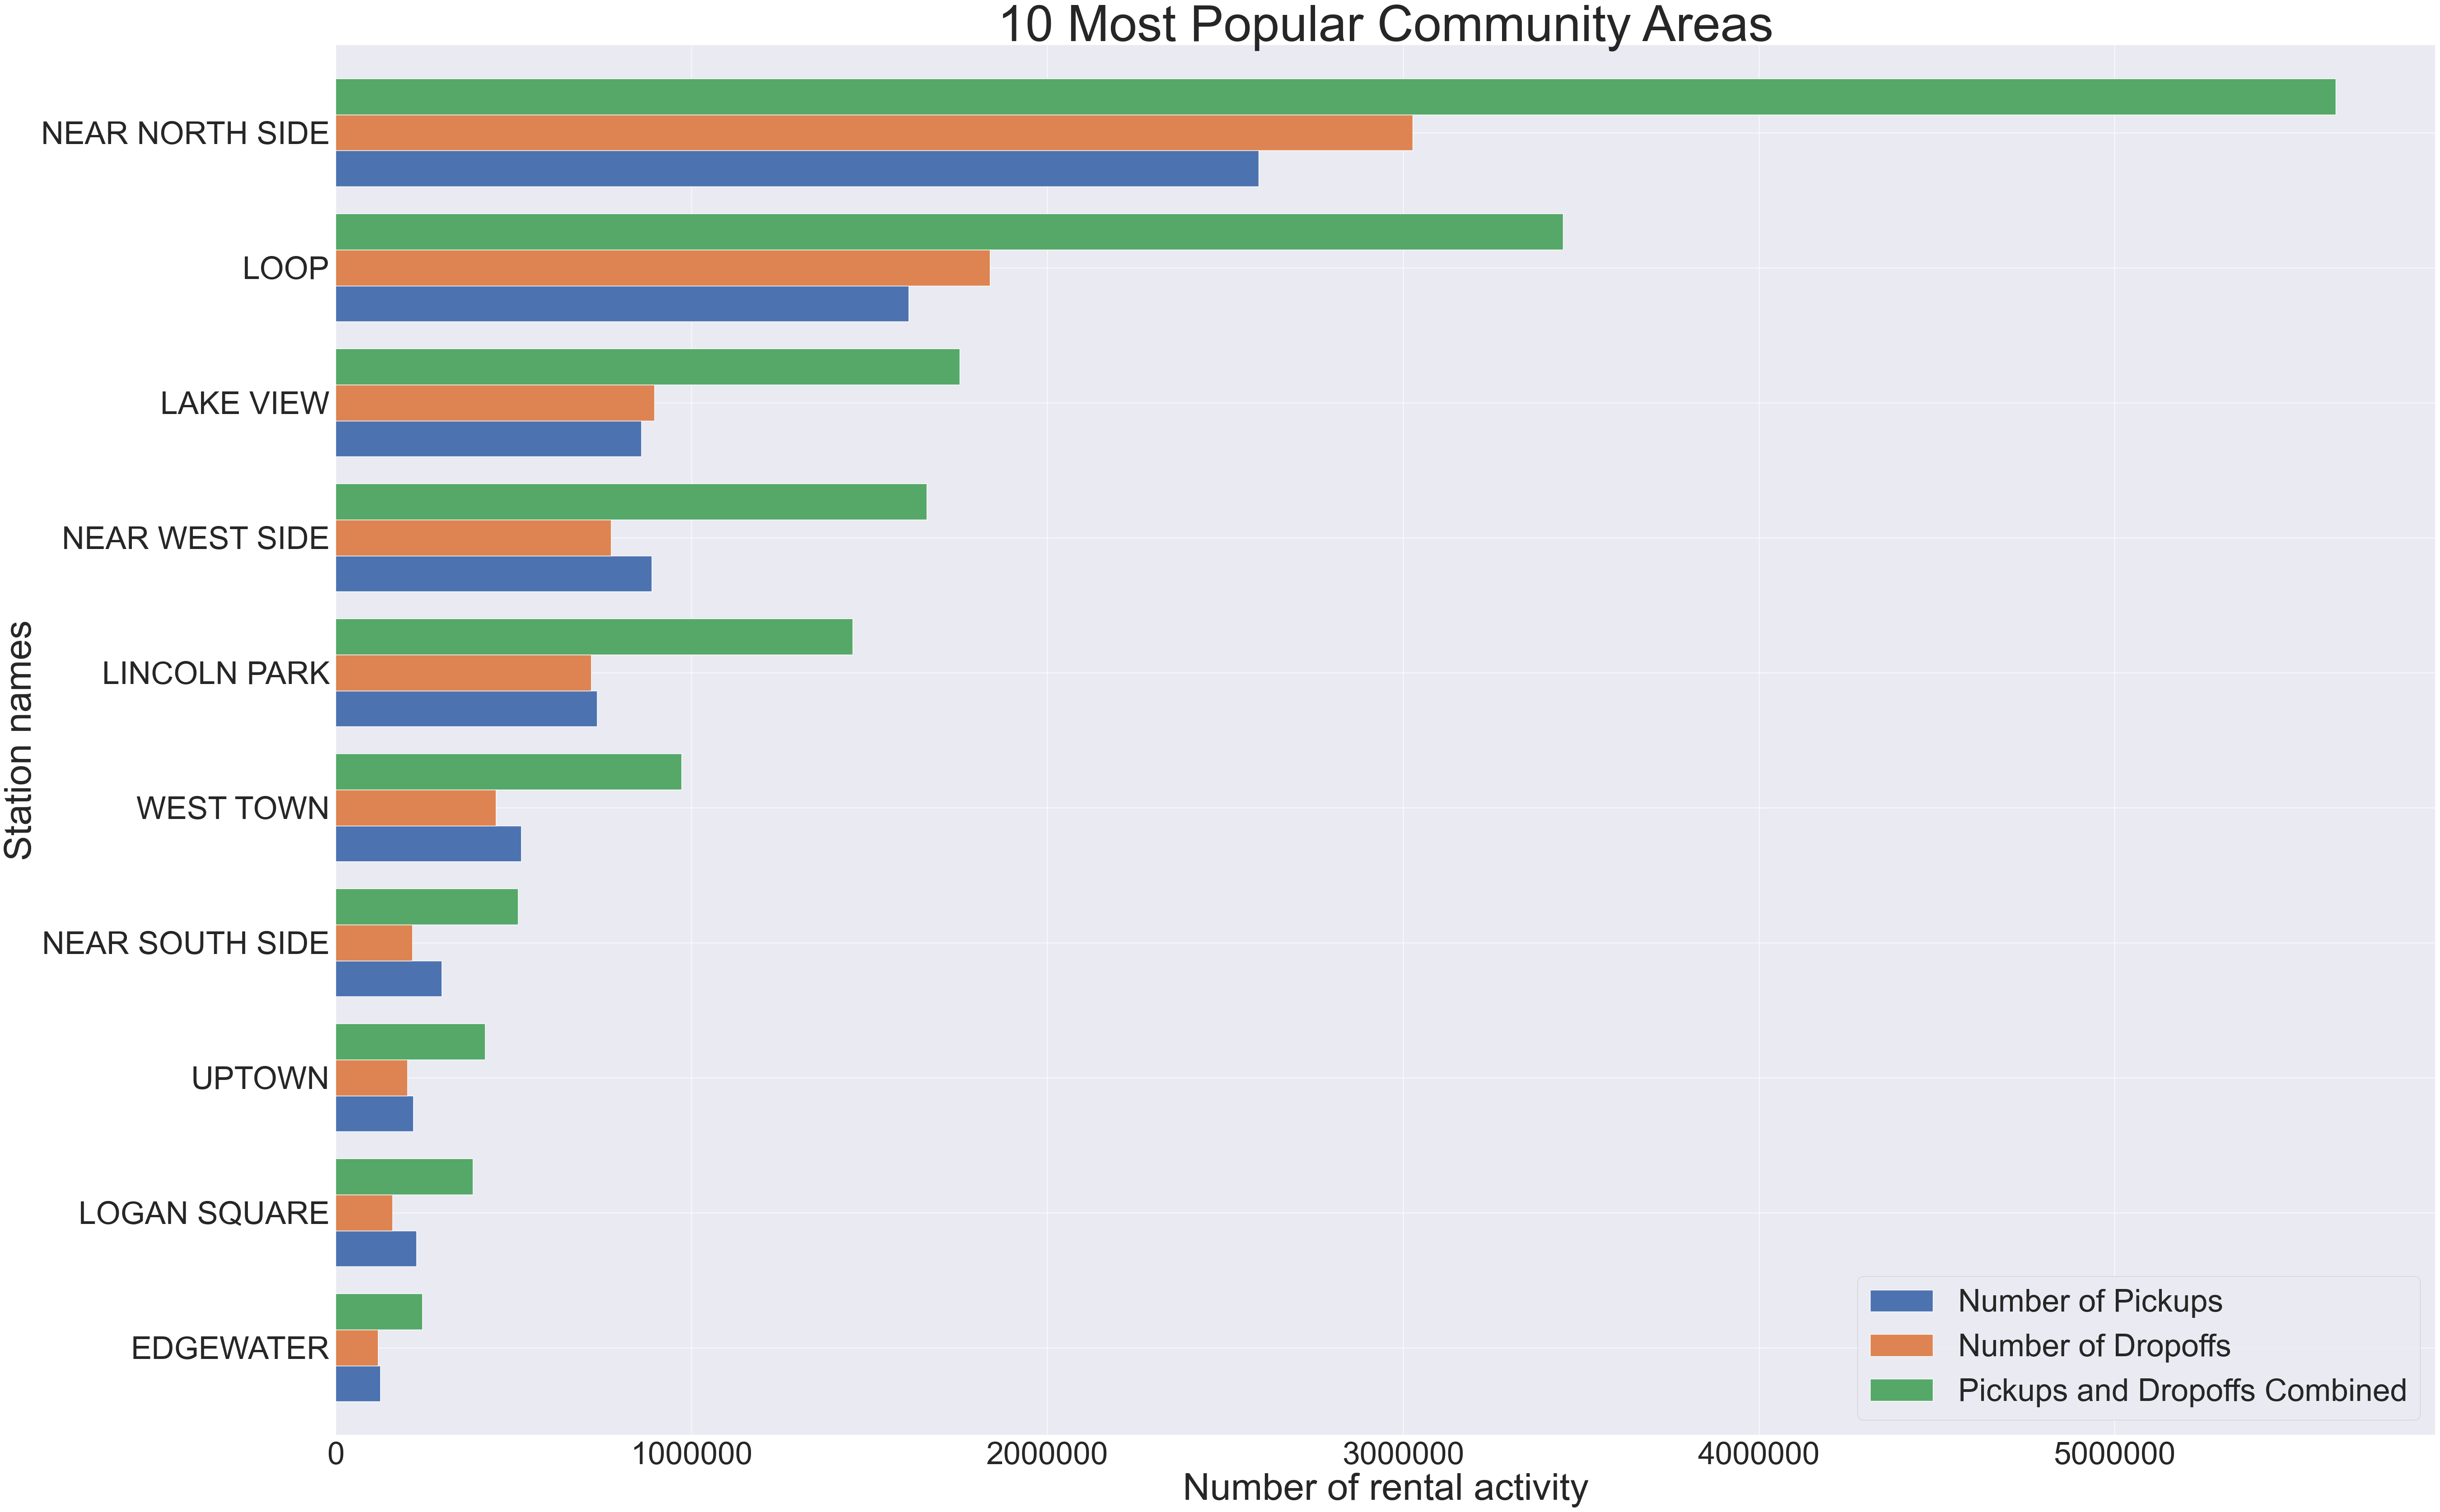

In [22]:
plot_popularity_stations('most popular', 10)
plt.legend(["Number of Pickups", "Number of Dropoffs", "Pickups and Dropoffs Combined"],
    prop={'size': 50})
plt.xlabel("Number of rental activity")
plt.show()

#### Visualization of Data for the Least Popular Community Areas in Chicago

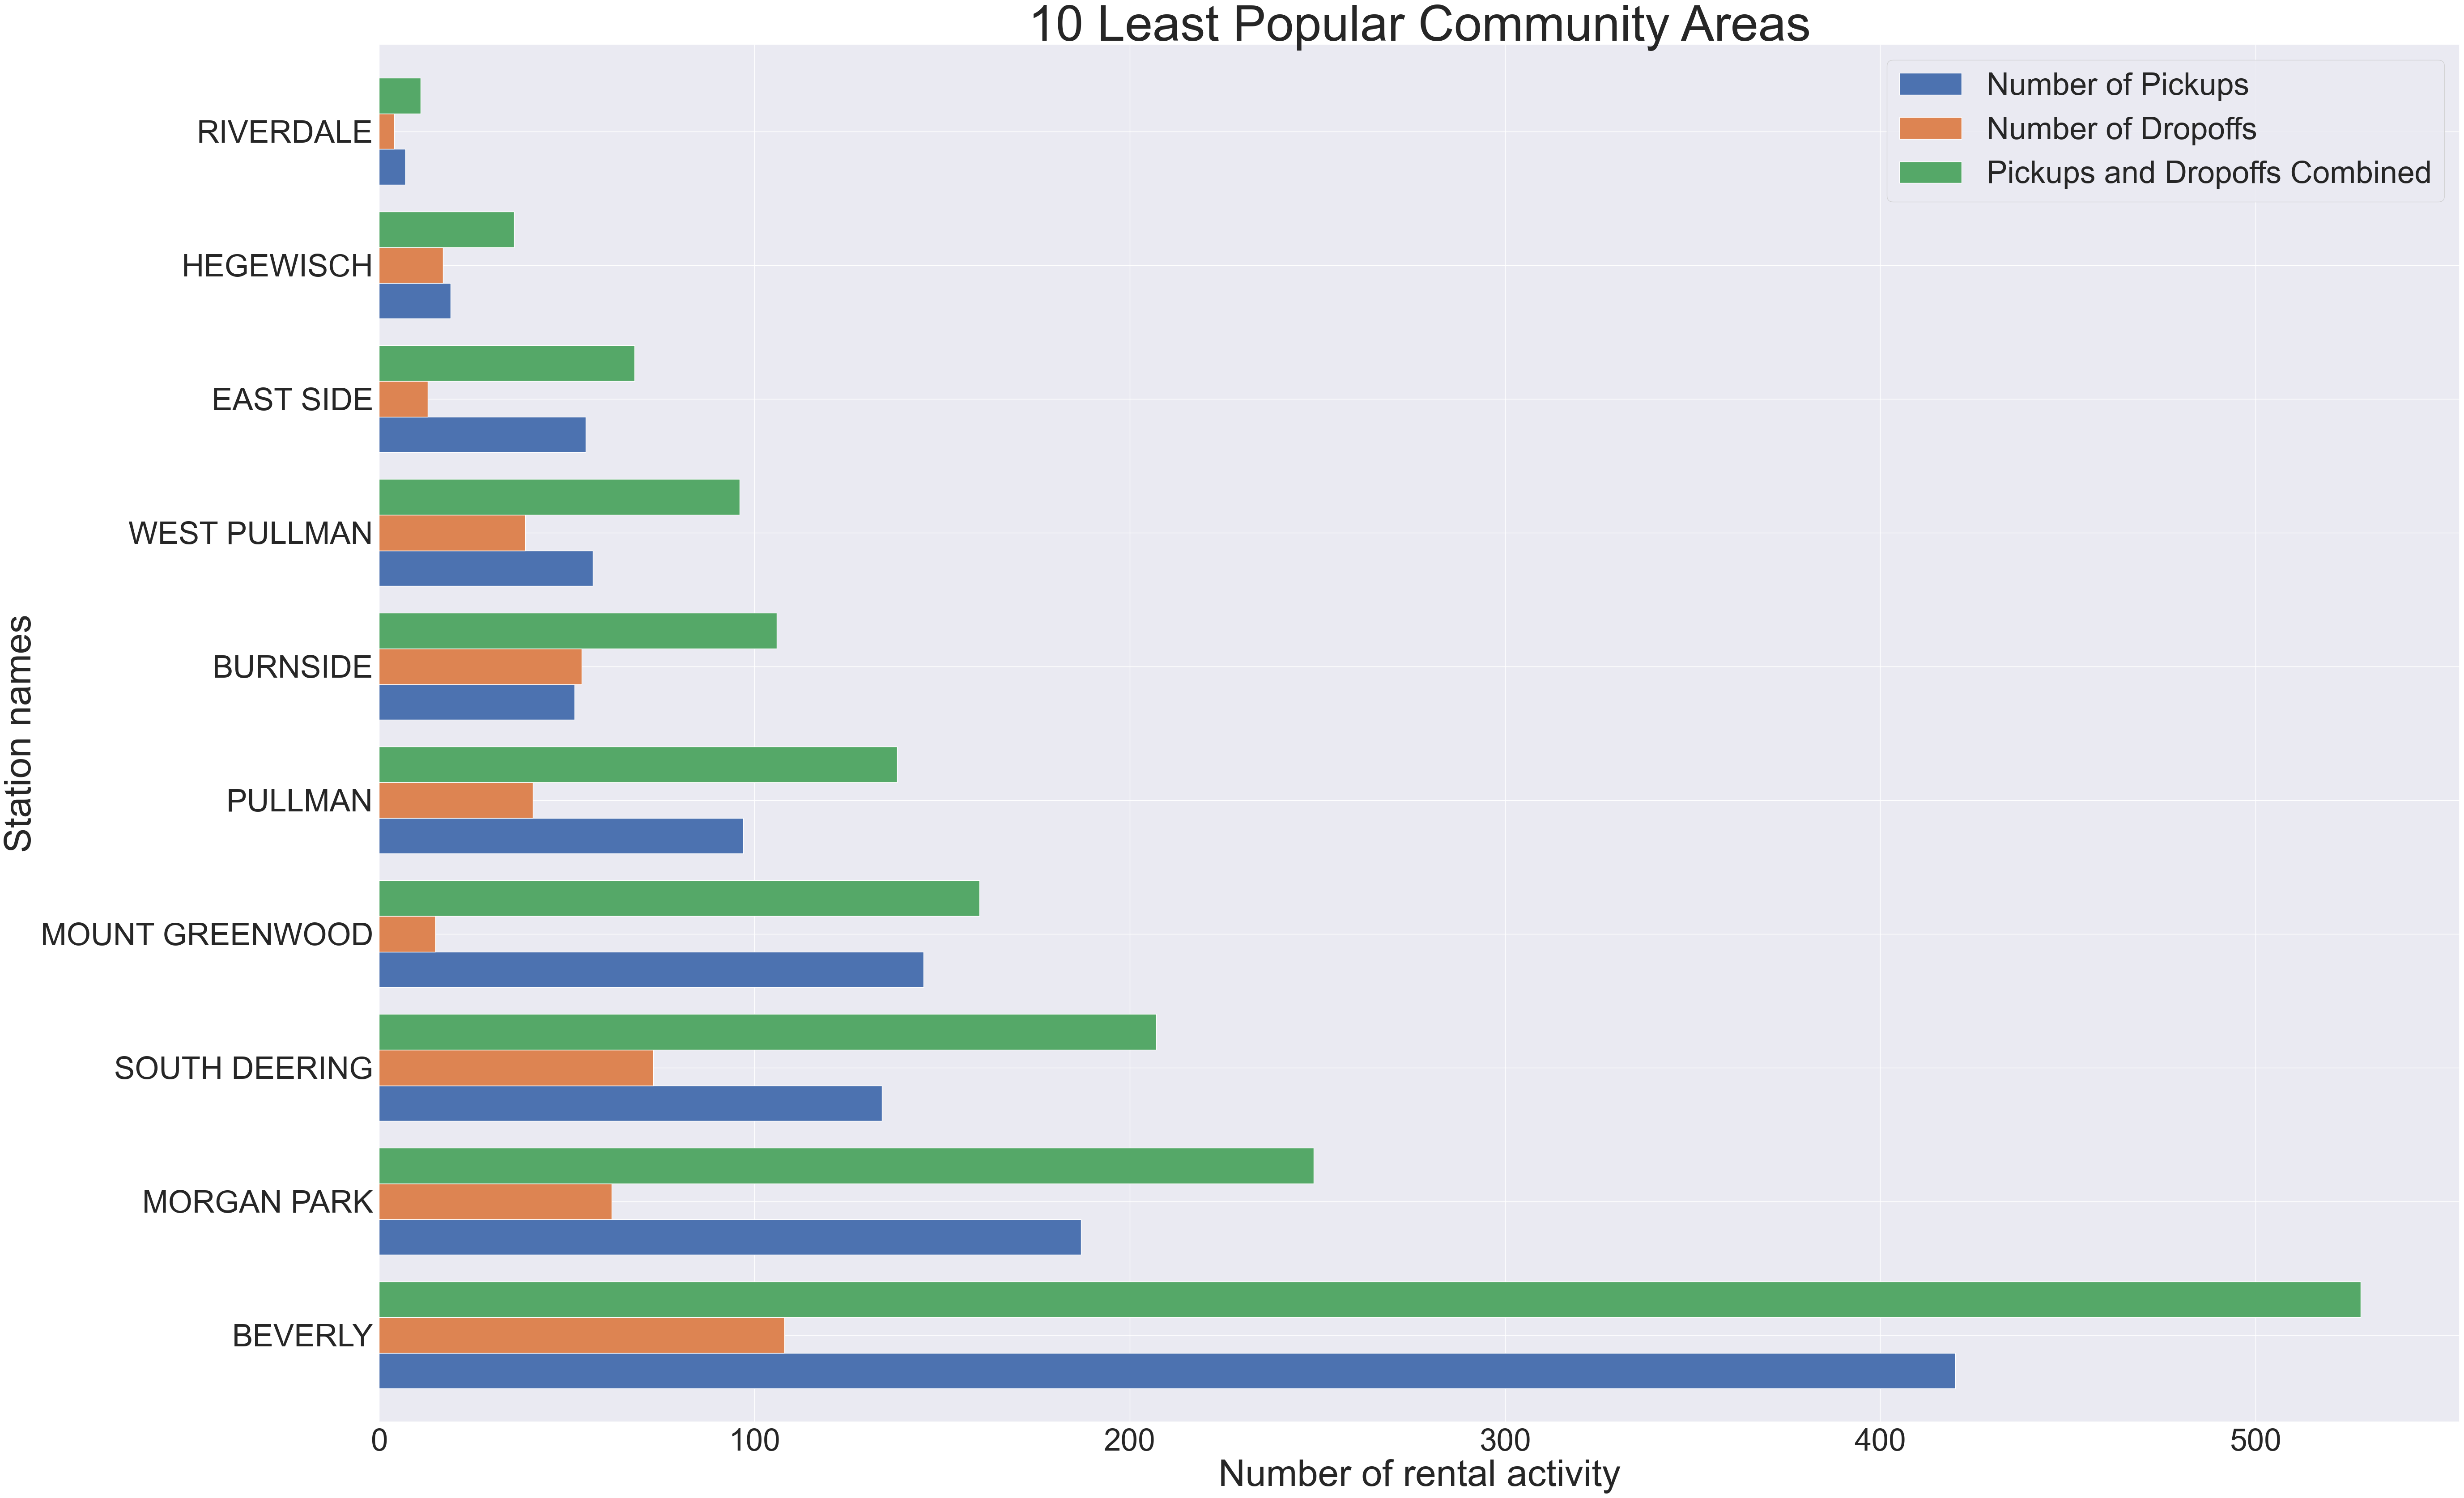

In [23]:
popularity_stations.sort_values(by=['Community_Area_Popularity'], ascending=False, inplace=True)

plot_popularity_stations('least popular', 10)
plt.legend(["Number of Pickups", "Number of Dropoffs", "Pickups and Dropoffs Combined"],
    prop={'size': 50})
plt.xlabel("Number of rental activity")
plt.show()

#### 3.1.3 Visualization of Most & Least Popular Community Areas on a Map

In [24]:
import geopandas as gpd

# Load the GeoJSON file containing Chicago's community area boundaries
# Replace 'path_to_geojson_file.geojson' with the actual file path
geojson_path = '..\data\community_areas.geojson'
gdf = gpd.read_file(geojson_path)

In [25]:
# Calculate the 5 most and least popular community areas
top_10_popular = Community_Area_Popularity.nlargest(10, 'Community_Area_Popularity')
top_10_least_popular = Community_Area_Popularity.nsmallest(10, 'Community_Area_Popularity')

# Combine the two DataFrames
highlighted_areas = top_10_popular['Community_Area_Name'].tolist() + top_10_least_popular['Community_Area_Name'].tolist()

highlighted_areas

['NEAR NORTH SIDE',
 'LOOP',
 'LAKE VIEW',
 'NEAR WEST SIDE',
 'LINCOLN PARK',
 'WEST TOWN',
 'NEAR SOUTH SIDE',
 'UPTOWN',
 'LOGAN SQUARE',
 'EDGEWATER',
 'RIVERDALE',
 'HEGEWISCH',
 'EAST SIDE',
 'WEST PULLMAN',
 'BURNSIDE',
 'PULLMAN',
 'MOUNT GREENWOOD',
 'SOUTH DEERING',
 'MORGAN PARK',
 'BEVERLY']

In [26]:
# Create a mapping DataFrame for Community_Area_Popularity
popularity_mapping = Community_Area_Popularity[['Community_Area_Name', 'Community_Area_Popularity']]

# Merge the popularity values into the GeoJSON DataFrame
gdf = gdf.merge(popularity_mapping, left_on='community', right_on='Community_Area_Name', how='left')

In [37]:
# Coordinates of the city center of chicogo according to https://www.findlatitudeandlongitude.com/l/Chicago+City+centre/5712575/
chicago_city_center = (41.879519, -87.633026)

m_most_least_popular_community_areas = folium.Map(location=chicago_city_center, zoom_start=11, tiles='cartodbpositron')

# Define the style function for the GeoJSON layer
def style_function(feature):
    geojson_community = feature['properties']['community']
    
    if geojson_community in top_10_least_popular['Community_Area_Name'].tolist():
        return {
            'color': 'red',      # Least popular areas in red
            'weight': 4,         # Border weight for highlighted areas
            'fillOpacity': 0.1   # Fill opacity for highlighted areas
        }
    elif geojson_community in top_10_popular['Community_Area_Name'].tolist():
        return {
            'color': 'green',    # Most popular areas in green
            'weight': 4,         # Border weight for highlighted areas
            'fillOpacity': 0.1   # Fill opacity for highlighted areas
        }
    
    return {
        'color': 'blue',         # Border color for non-highlighted areas
        'weight': 2,             # Border weight for non-highlighted areas
        'fillOpacity': 0         # No fill
    }

# Add GeoJSON layer for community area boundaries
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['community', 'Community_Area_Popularity'],  # Field(s) from GeoJSON properties to display
        aliases=['Community Area', 'Popularity'],  # Alias for field(s)
        localize=True  # If True, format numbers and dates according to the browser locale
    )
).add_to(m_most_least_popular_community_areas)

# Add a CircleMarker for the Chicago city center with a label
folium.CircleMarker(
    location=chicago_city_center,
    radius=5,  
    color='black',  
    fill=True,
    fill_color='black',  
    popup='City Center',  
    tooltip='City Center' 
).add_to(m_most_least_popular_community_areas)

# Show the map
m_most_least_popular_community_areas

<hr style="border: 1px solid #8888;">

## 3.2 Hard Clustering Location-based Analysis for Popularity in Community Areas: 
#### Features: `Centroid_Latitude`, `Centroid_Longitude` & `Community_Area_Popularity`

Popularity means Number of Pickups & Dropoffs Combined

### 3.2.1 Data Preparation

In [34]:
# Feature selection - hc in the dataframe name emphasizes the hard clustering approach
dfChicago_clu_popularity_hc = Community_Area_Popularity[['Community_Area_Name', 'Centroid_Latitude', 'Centroid_Longitude', 'Community_Area_Popularity']]

# Set 'Community_Area_Name' column as the index
dfChicago_clu_popularity_hc.set_index('Community_Area_Name', inplace=True)

# Display the DataFrame
dfChicago_clu_popularity_hc


Centroid_Latitude  Centroid_Longitude  \
Community_Area_Name                                          
RIVERDALE                    41.660136          -87.602848   
HEGEWISCH                    41.663671          -87.540936   
EAST SIDE                    41.707311          -87.534903   
WEST PULLMAN                 41.673820          -87.635740   
BURNSIDE                     41.728182          -87.596476   
...                                ...                 ...   
LINCOLN PARK                 41.922686          -87.649489   
NEAR WEST SIDE               41.874005          -87.663518   
LAKE VIEW                    41.944227          -87.655998   
LOOP                         41.878866          -87.625192   
NEAR NORTH SIDE              41.899602          -87.633308   

                     Community_Area_Popularity  
Community_Area_Name                             
RIVERDALE                                   11  
HEGEWISCH                                   36  
EAST SIDE                                   68  
WEST PULLMAN                                96  
BURNSIDE                                   106  
...                                        ...  
LINCOLN PARK                           1453369  
NEAR WEST SIDE                         1661454  
LAKE VIEW                              1754298  
LOOP                                   3449455  
NEAR NORTH SIDE                        5621272  

[77 rows x 3 columns]

#### Scaling the Data

In [35]:
# Scaling the data
dfChicago_clu_popularity_hc_scaled = scaling_data(dfChicago_clu_popularity_hc)

### 3.2.2 Validation of Number of Clusters

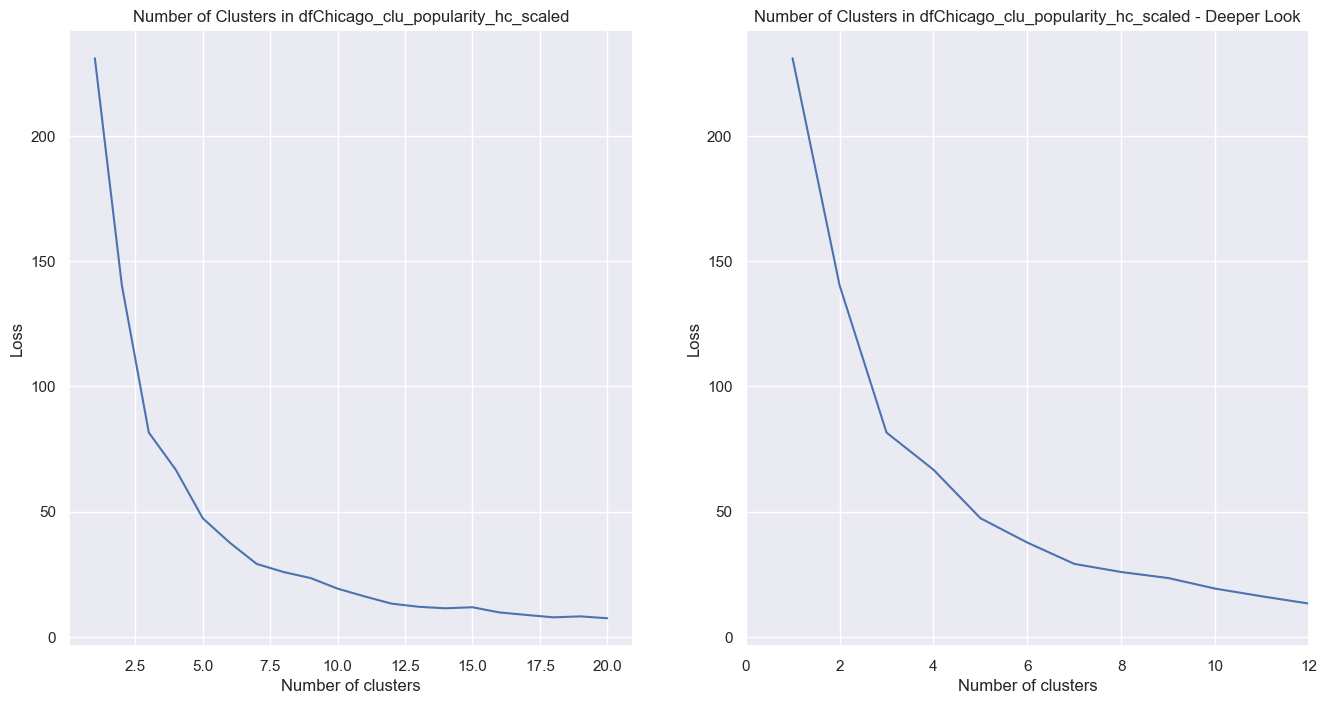

In [36]:
plot_best_fitting_number_of_clusters(dfChicago_clu_popularity_hc_scaled, "in dfChicago_clu_popularity_hc_scaled")

### 2.2.3 Computing Clusters with k-means++

In [37]:
# initializing our kmeans algorithm 
kmean = KMeans(n_clusters=5,init='k-means++', random_state=42)

# fitting our scaled data to the model
kmean.fit(dfChicago_clu_popularity_hc_scaled)

# store the predicted clusters 
Clusters = kmean.predict(dfChicago_clu_popularity_hc_scaled)

# creating a column for the calculated clusters

dfChicago_clu_popularity_hc.loc[:, 'cluster_number'] = Clusters
dfChicago_clu_popularity_hc

c:\Users\jonas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\274674016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_popularity_hc.loc[:, 'cluster_number'] = Clusters


Centroid_Latitude  Centroid_Longitude  \
Community_Area_Name                                          
RIVERDALE                    41.660136          -87.602848   
HEGEWISCH                    41.663671          -87.540936   
EAST SIDE                    41.707311          -87.534903   
WEST PULLMAN                 41.673820          -87.635740   
BURNSIDE                     41.728182          -87.596476   
...                                ...                 ...   
LINCOLN PARK                 41.922686          -87.649489   
NEAR WEST SIDE               41.874005          -87.663518   
LAKE VIEW                    41.944227          -87.655998   
LOOP                         41.878866          -87.625192   
NEAR NORTH SIDE              41.899602          -87.633308   

                     Community_Area_Popularity  cluster_number  
Community_Area_Name                                             
RIVERDALE                                   11               0  
HEGEWISCH                                   36               0  
EAST SIDE                                   68               0  
WEST PULLMAN                                96               0  
BURNSIDE                                   106               0  
...                                        ...             ...  
LINCOLN PARK                           1453369               3  
NEAR WEST SIDE                         1661454               3  
LAKE VIEW                              1754298               3  
LOOP                                   3449455               2  
NEAR NORTH SIDE                        5621272               2  

[77 rows x 4 columns]

### 2.2.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


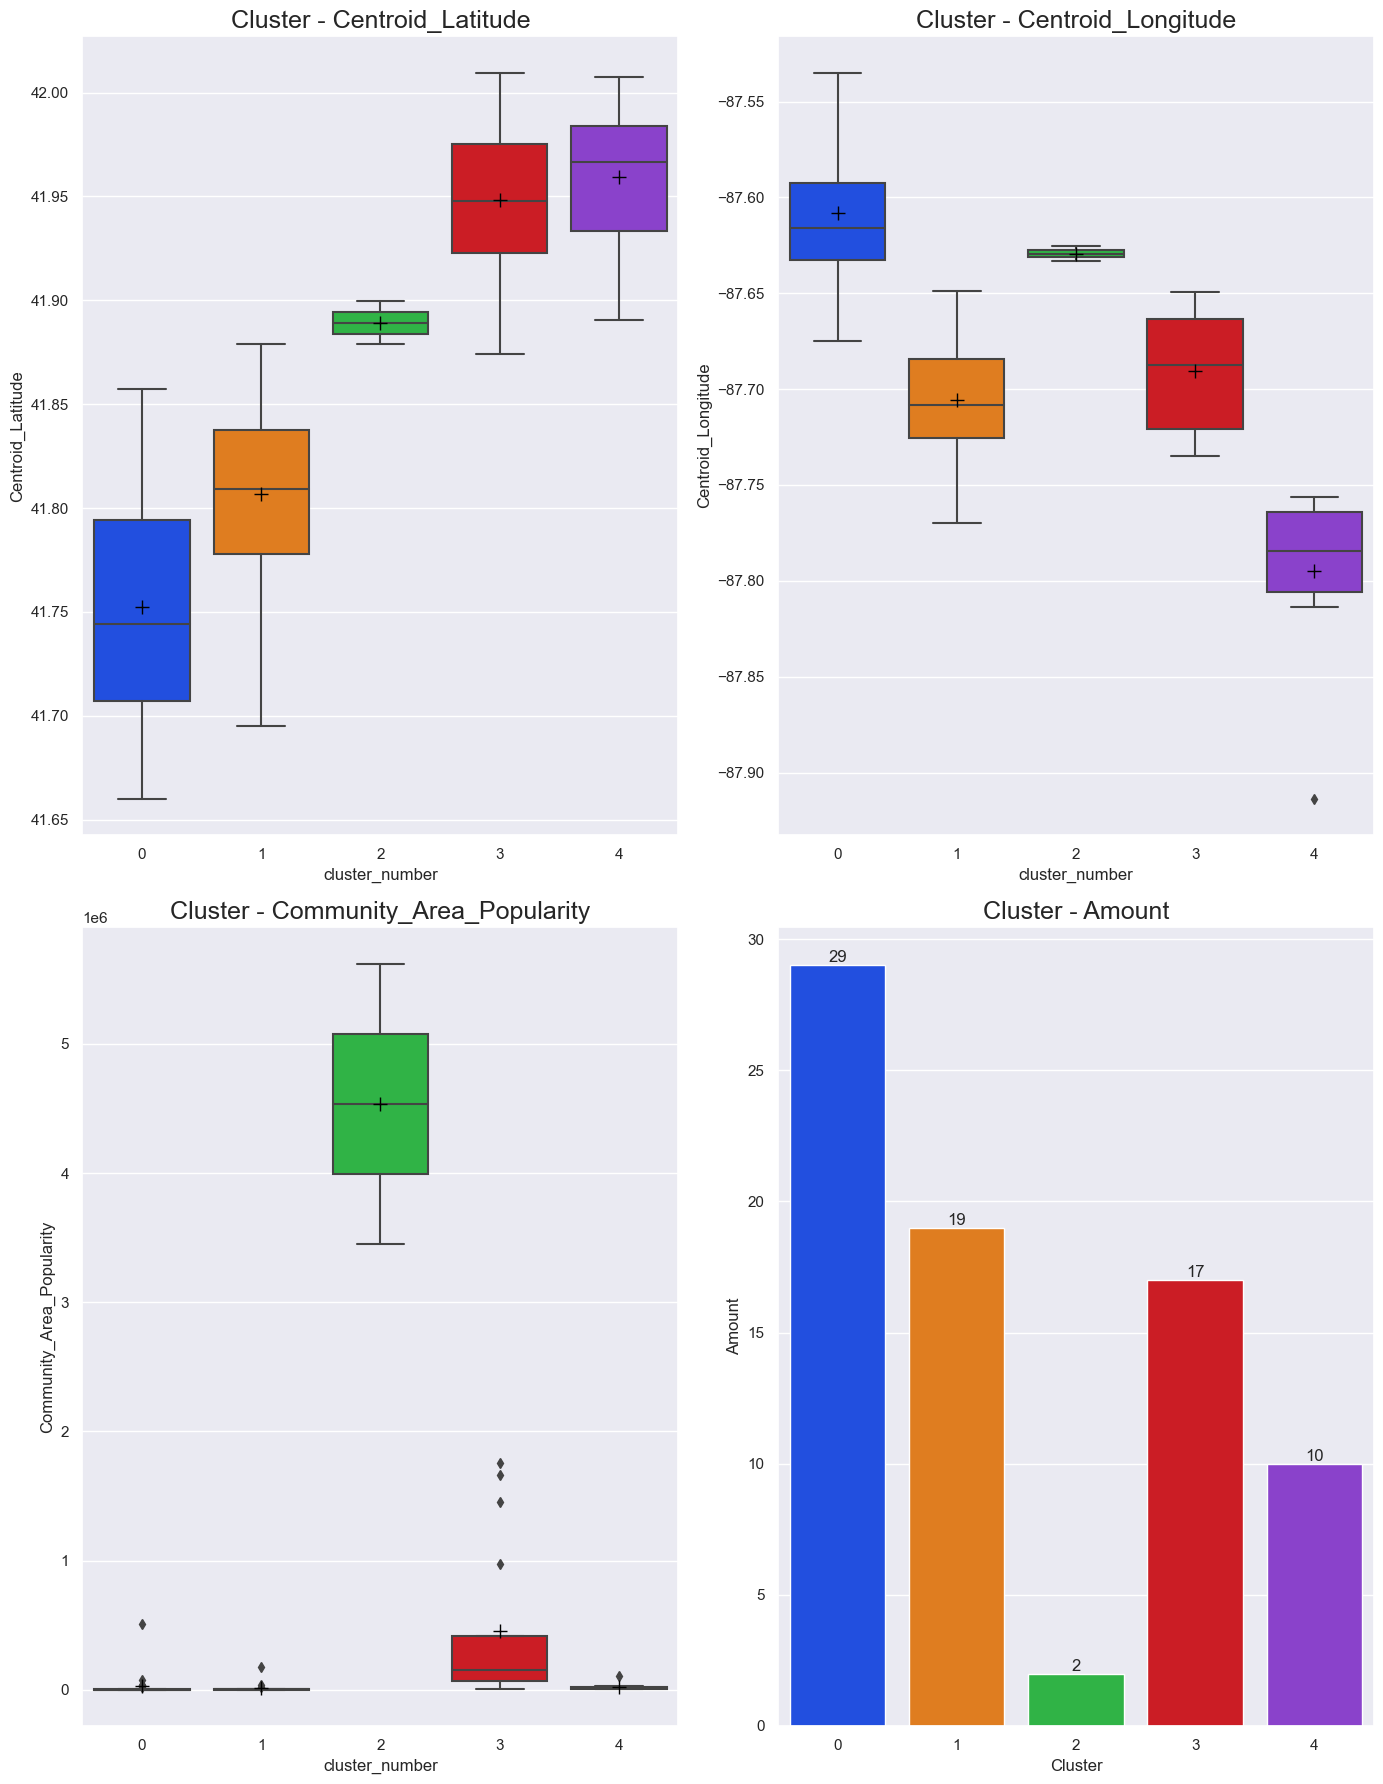

In [38]:
plot_information_about_clusters(dfChicago_clu_popularity_hc, ['Centroid_Latitude', 'Centroid_Longitude', 'Community_Area_Popularity'], 'cluster_number')

In [39]:
label_names = {0: 'blue',
                1: 'orange',
                2: 'green',
                3: 'red',
                4: 'purple',
                5: 'brown',
                6: 'pink',
                7: 'gray',
                8: 'yellow',
                9: 'lightblue',
            }

# integrating our labeled clusters in the dataframe
dfChicago_clu_popularity_hc['Cluster_Label'] = dfChicago_clu_popularity_hc['cluster_number'].astype(str)
dfChicago_clu_popularity_hc = dfChicago_clu_popularity_hc.replace({"Cluster_Label": label_names})

# Reset the index to make 'Community_Area_Name' a regular column
dfChicago_clu_popularity_hc.reset_index(inplace=True)

dfChicago_clu_popularity_hc

C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\3455354375.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_popularity_hc['Cluster_Label'] = dfChicago_clu_popularity_hc['cluster_number'].astype(str)


Community_Area_Name  Centroid_Latitude  Centroid_Longitude  \
0            RIVERDALE          41.660136          -87.602848   
1            HEGEWISCH          41.663671          -87.540936   
2            EAST SIDE          41.707311          -87.534903   
3         WEST PULLMAN          41.673820          -87.635740   
4             BURNSIDE          41.728182          -87.596476   
..                 ...                ...                 ...   
72        LINCOLN PARK          41.922686          -87.649489   
73      NEAR WEST SIDE          41.874005          -87.663518   
74           LAKE VIEW          41.944227          -87.655998   
75                LOOP          41.878866          -87.625192   
76     NEAR NORTH SIDE          41.899602          -87.633308   

    Community_Area_Popularity  cluster_number Cluster_Label  
0                          11               0             0  
1                          36               0             0  
2                          68               0             0  
3                          96               0             0  
4                         106               0             0  
..                        ...             ...           ...  
72                    1453369               3             3  
73                    1661454               3             3  
74                    1754298               3             3  
75                    3449455               2             2  
76                    5621272               2             2  

[77 rows x 6 columns]

### 3.2.5 Displaying Results on a Map of Chicago

In [86]:
m_popularity_hc = folium.Map(location=chicago_city_center, zoom_start=10, tiles='cartodbpositron')

# Define the style function for the GeoJSON layer
def style_function(feature):
    geojson_community = feature['properties']['community']
    
    # Check if geojson_community is in the DataFrame
    if geojson_community in dfChicago_clu_popularity_hc['Community_Area_Name'].tolist():
        cluster_label = dfChicago_clu_popularity_hc[dfChicago_clu_popularity_hc['Community_Area_Name'] == geojson_community]['cluster_number'].values[0]

        # Define a dictionary to map cluster labels to colors
        color_mapping = {0: 'blue',
                1: 'orange',
                2: 'green',
                3: 'red',
                4: 'purple',
                5: 'brown',
                6: 'pink',
                7: 'gray',
                8: 'yellow',
                9: 'lightblue',
            }
        return {
                'color': color_mapping.get(cluster_label, 'black'),  # Color for areas in the DataFrame  
                'weight': 4,         # Border weight for highlighted areas
                'fillOpacity': 0.1   # Fill opacity for highlighted areas
            }

    else:
        return {
            'color': 'black',      # Color for areas not in the DataFrame
            'weight': 2,          # Border weight
            'fillOpacity': 0      # No fill
        }

# Add GeoJSON layer for community area boundaries
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['community', 'Community_Area_Popularity'],  # Field(s) from GeoJSON properties to display
        aliases=['Community Area', 'Popularity'],  # Alias for field(s)
        localize=True  # If True, format numbers and dates according to the browser locale
    )
).add_to(m_popularity_hc)

# Show the map
m_popularity_hc


<hr style="border: 1px solid #8888;">

## 3.3 Soft Clustering Location-based Analysis for Popularity in Community Areas: 
#### Features: `Centroid_Latitude`, `Centroid_Longitude` & `Community_Area_Popularity`

Popularity means Number of Pickups & Dropoffs Combined

### 3.2.1 Data Preparation

In [42]:
# Feature selection - hc in the dataframe name emphasizes the hard clustering approach
dfChicago_clu_popularity_sc = Community_Area_Popularity[['Community_Area_Name', 'Centroid_Latitude', 'Centroid_Longitude', 'Community_Area_Popularity']]

# Set 'Community_Area_Name' column as the index
dfChicago_clu_popularity_sc.set_index('Community_Area_Name', inplace=True)

# Display the DataFrame
dfChicago_clu_popularity_sc

Centroid_Latitude  Centroid_Longitude  \
Community_Area_Name                                          
RIVERDALE                    41.660136          -87.602848   
HEGEWISCH                    41.663671          -87.540936   
EAST SIDE                    41.707311          -87.534903   
WEST PULLMAN                 41.673820          -87.635740   
BURNSIDE                     41.728182          -87.596476   
...                                ...                 ...   
LINCOLN PARK                 41.922686          -87.649489   
NEAR WEST SIDE               41.874005          -87.663518   
LAKE VIEW                    41.944227          -87.655998   
LOOP                         41.878866          -87.625192   
NEAR NORTH SIDE              41.899602          -87.633308   

                     Community_Area_Popularity  
Community_Area_Name                             
RIVERDALE                                   11  
HEGEWISCH                                   36  
EAST SIDE                                   68  
WEST PULLMAN                                96  
BURNSIDE                                   106  
...                                        ...  
LINCOLN PARK                           1453369  
NEAR WEST SIDE                         1661454  
LAKE VIEW                              1754298  
LOOP                                   3449455  
NEAR NORTH SIDE                        5621272  

[77 rows x 3 columns]

#### Scaling the Data

In [43]:
# Scaling the data
dfChicago_clu_popularity_sc_scaled = scaling_data(dfChicago_clu_popularity_sc)

### 3.2.2 Validation of Number of Clusters

### Silhouette score

In [51]:
clusters_sil, scores_sil = silhoutte(dfChicago_clu_popularity_sc_scaled, 6)

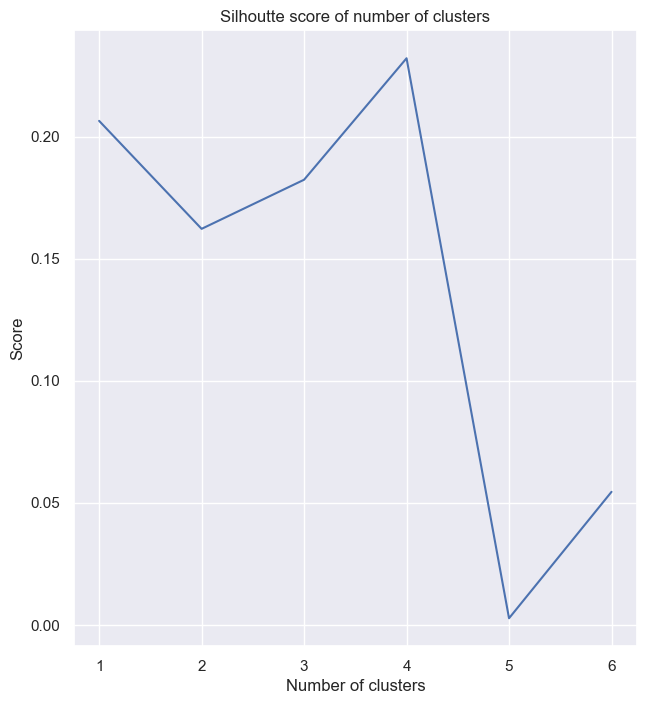

In [52]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.show()

### Bayesian information criterion (BIC)

In [59]:
clusters_bic, scores_bic = bic(dfChicago_clu_popularity_sc_scaled, 6)

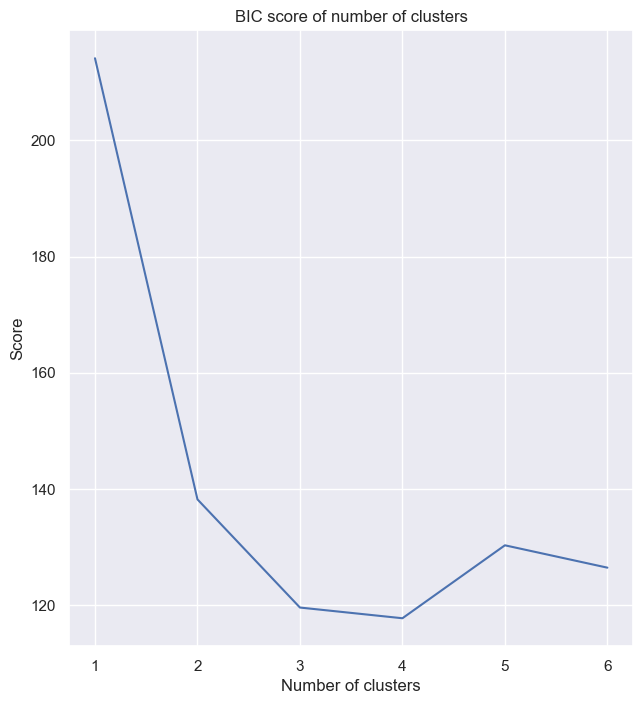

In [60]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.show()

We decide to choose 4 clusters, since we have a peak in the silhouette score and the BIC score increases from 4 clusters again. This relationship indicates that 4 is the optimal number of clusters.

### 2.2.3 Computing Clusters with Gaussian Mixture Model (GMM)

In [61]:
gm = GaussianMixture(n_components=4, random_state=42, n_init = 15).fit(dfChicago_clu_popularity_sc_scaled)

In [62]:
cluster = gm.predict(dfChicago_clu_popularity_sc_scaled)

In [63]:
cluster_prob = gm.predict_proba(dfChicago_clu_popularity_sc_scaled)

In [64]:
dfChicago_clu_popularity_sc["cluster"] = cluster

C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\3476786770.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_popularity_sc["cluster"] = cluster


In [65]:
for k in range(4):
    dfChicago_clu_popularity_sc[f"cluster_{k}_prob"] = cluster_prob[:, k]

C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1197047373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfChicago_clu_popularity_sc[f"cluster_{k}_prob"] = cluster_prob[:, k]


In [66]:
dfChicago_clu_popularity_sc

Centroid_Latitude  Centroid_Longitude  \
Community_Area_Name                                          
RIVERDALE                    41.660136          -87.602848   
HEGEWISCH                    41.663671          -87.540936   
EAST SIDE                    41.707311          -87.534903   
WEST PULLMAN                 41.673820          -87.635740   
BURNSIDE                     41.728182          -87.596476   
...                                ...                 ...   
LINCOLN PARK                 41.922686          -87.649489   
NEAR WEST SIDE               41.874005          -87.663518   
LAKE VIEW                    41.944227          -87.655998   
LOOP                         41.878866          -87.625192   
NEAR NORTH SIDE              41.899602          -87.633308   

                     Community_Area_Popularity  cluster  cluster_0_prob  \
Community_Area_Name                                                       
RIVERDALE                                   11        1    4.094469e-30   
HEGEWISCH                                   36        1    3.124217e-17   
EAST SIDE                                   68        1    2.442426e-08   
WEST PULLMAN                                96        1    1.976448e-33   
BURNSIDE                                   106        1    9.975765e-13   
...                                        ...      ...             ...   
LINCOLN PARK                           1453369        2    0.000000e+00   
NEAR WEST SIDE                         1661454        2    0.000000e+00   
LAKE VIEW                              1754298        2    0.000000e+00   
LOOP                                   3449455        3    0.000000e+00   
NEAR NORTH SIDE                        5621272        3    0.000000e+00   

                     cluster_1_prob  cluster_2_prob  cluster_3_prob  
Community_Area_Name                                                  
RIVERDALE                       1.0    4.820315e-21             0.0  
HEGEWISCH                       1.0    1.051153e-24             0.0  
EAST SIDE                       1.0    4.625271e-21             0.0  
WEST PULLMAN                    1.0    1.426497e-18             0.0  
BURNSIDE                        1.0    3.375067e-15             0.0  
...                             ...             ...             ...  
LINCOLN PARK                    0.0    1.000000e+00             0.0  
NEAR WEST SIDE                  0.0    1.000000e+00             0.0  
LAKE VIEW                       0.0    1.000000e+00             0.0  
LOOP                            0.0    1.692680e-10             1.0  
NEAR NORTH SIDE                 0.0    7.246184e-28             1.0  

[77 rows x 8 columns]

### 2.2.4 Analyzing Clusters & Labeling them

C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\jonas\AppData\Local\Temp\ipykernel_1112\1267026547.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


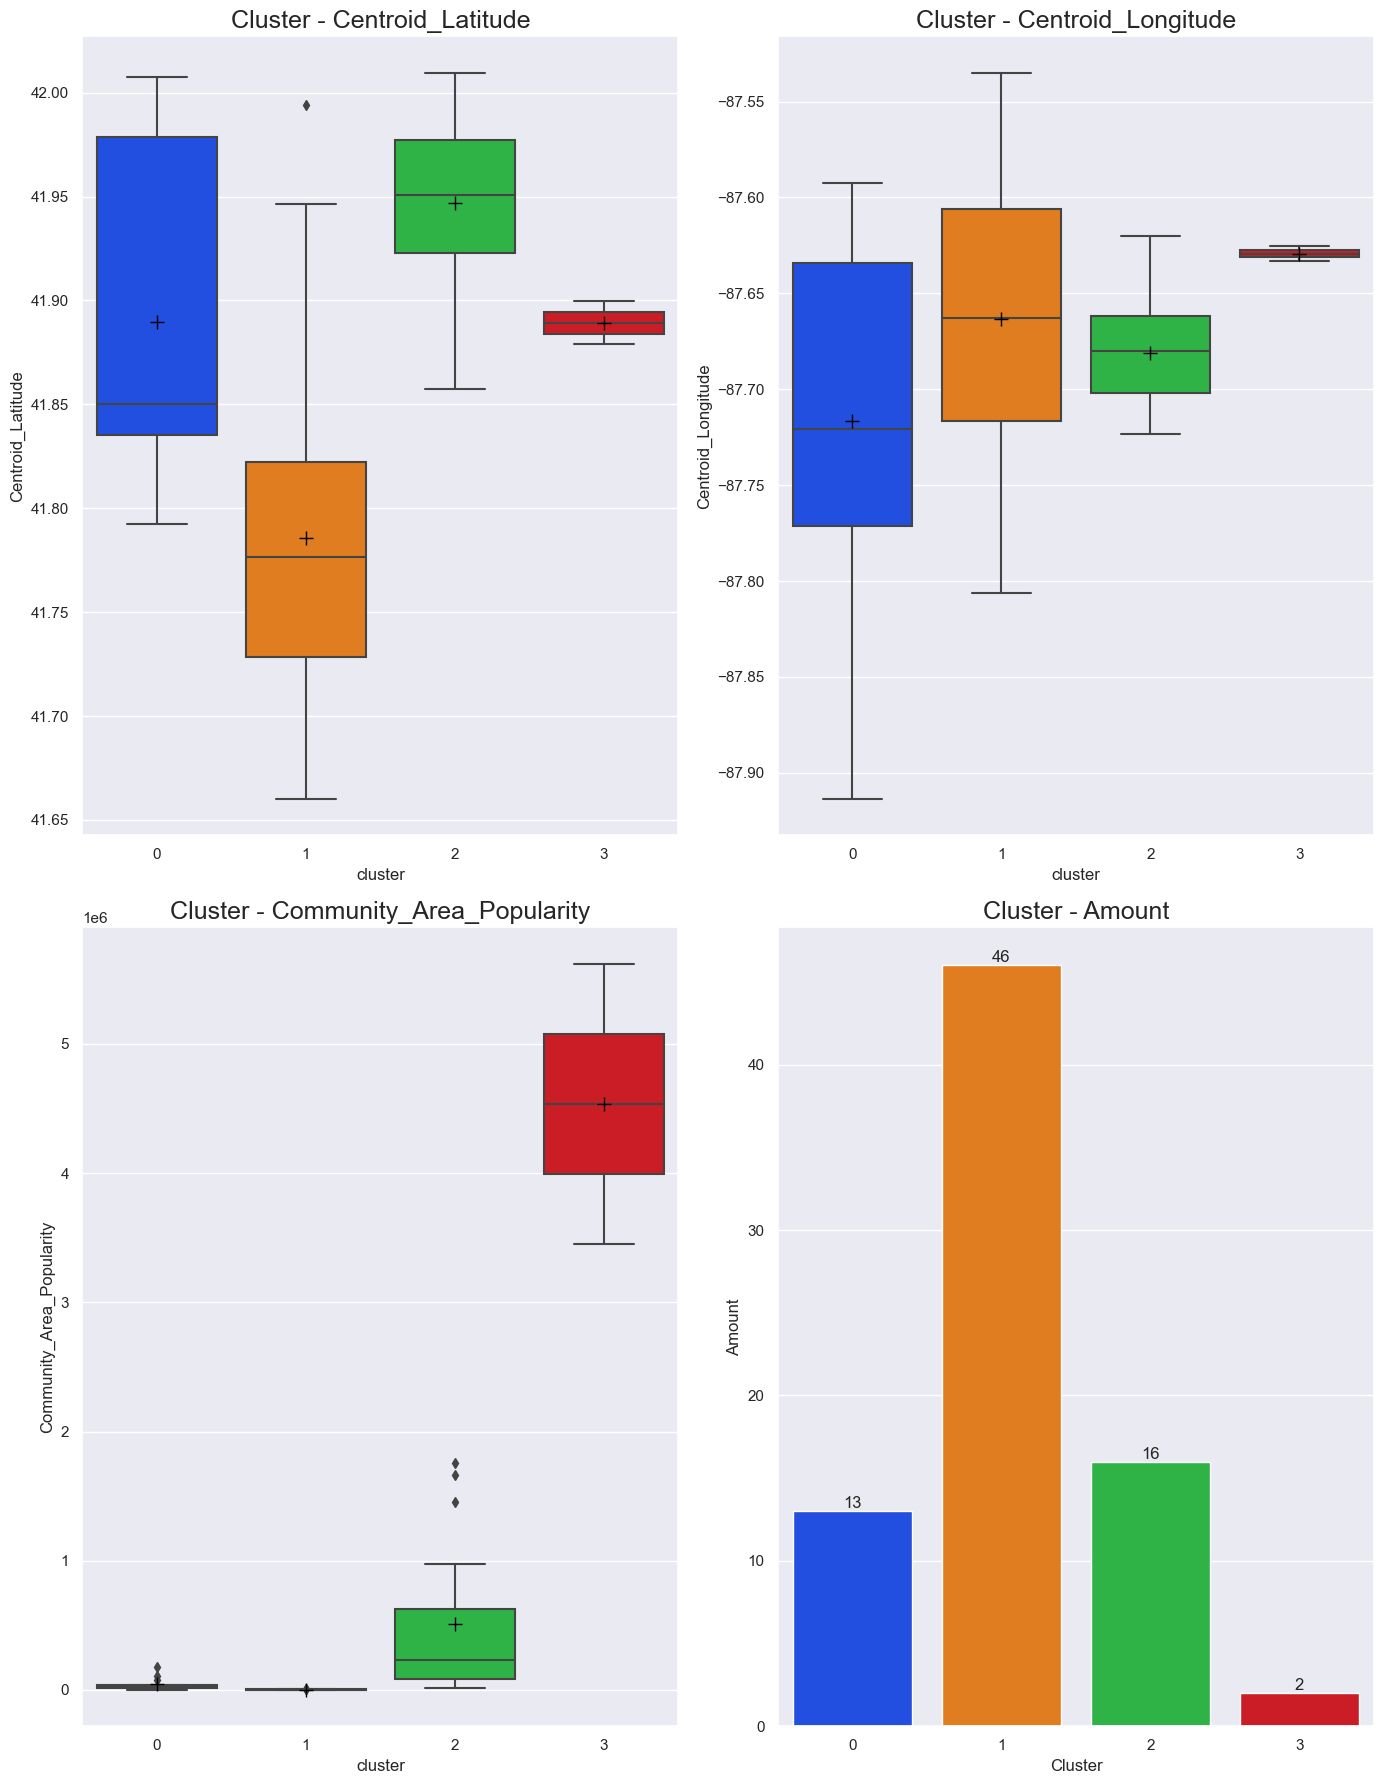

In [67]:
plot_information_about_clusters(dfChicago_clu_popularity_sc, ['Centroid_Latitude', 'Centroid_Longitude', 'Community_Area_Popularity'], 'cluster')

In [70]:
dfChicago_clu_popularity_sc_quantiles = get_quantiles_of_clusters(dfChicago_clu_popularity_sc, 4, 'cluster')
dfChicago_clu_popularity_sc_quantiles

Centroid_Latitude Centroid_Longitude Community_Area_Popularity  \
Cluster                                                                  
0           41.84 - 41.98    -87.77 - -87.63         18380.0 - 39928.0   
1           41.73 - 41.82    -87.72 - -87.61           732.5 - 4149.75   
2           41.92 - 41.98     -87.7 - -87.66       87842.25 - 626958.0   
3           41.88 - 41.89    -87.63 - -87.63   3992409.25 - 5078317.75   

        cluster_0_prob cluster_1_prob cluster_2_prob cluster_3_prob  \
Cluster                                                               
0            1.0 - 1.0      0.0 - 0.0      0.0 - 0.0      0.0 - 0.0   
1            0.0 - 0.0      1.0 - 1.0      0.0 - 0.0      0.0 - 0.0   
2            0.0 - 0.0      0.0 - 0.0      1.0 - 1.0      0.0 - 0.0   
3            0.0 - 0.0      0.0 - 0.0      0.0 - 0.0      1.0 - 1.0   

         Amount Trips in Cluster  Percentage  
Cluster                                       
0                           13.0       16.88  
1                           46.0       59.74  
2                           16.0       20.78  
3                            2.0        2.60

In [72]:
label_names = {0: 'blue',
                1: 'orange',
                2: 'green',
                3: 'red',
                4: 'purple',
                5: 'brown',
                6: 'pink',
                7: 'gray',
                8: 'yellow',
                9: 'lightblue',
            }

# integrating our labeled clusters in the dataframe
dfChicago_clu_popularity_sc['Cluster_Label'] = dfChicago_clu_popularity_sc['cluster'].astype(str)
dfChicago_clu_popularity_sc = dfChicago_clu_popularity_sc.replace({"Cluster_Label": label_names})

# Reset the index to make 'Community_Area_Name' a regular column
dfChicago_clu_popularity_sc.reset_index(inplace=True)

dfChicago_clu_popularity_sc

Community_Area_Name  Centroid_Latitude  Centroid_Longitude  \
0            RIVERDALE          41.660136          -87.602848   
1            HEGEWISCH          41.663671          -87.540936   
2            EAST SIDE          41.707311          -87.534903   
3         WEST PULLMAN          41.673820          -87.635740   
4             BURNSIDE          41.728182          -87.596476   
..                 ...                ...                 ...   
72        LINCOLN PARK          41.922686          -87.649489   
73      NEAR WEST SIDE          41.874005          -87.663518   
74           LAKE VIEW          41.944227          -87.655998   
75                LOOP          41.878866          -87.625192   
76     NEAR NORTH SIDE          41.899602          -87.633308   

    Community_Area_Popularity  cluster  cluster_0_prob  cluster_1_prob  \
0                          11        1    4.094469e-30             1.0   
1                          36        1    3.124217e-17             1.0   
2                          68        1    2.442426e-08             1.0   
3                          96        1    1.976448e-33             1.0   
4                         106        1    9.975765e-13             1.0   
..                        ...      ...             ...             ...   
72                    1453369        2    0.000000e+00             0.0   
73                    1661454        2    0.000000e+00             0.0   
74                    1754298        2    0.000000e+00             0.0   
75                    3449455        3    0.000000e+00             0.0   
76                    5621272        3    0.000000e+00             0.0   

    cluster_2_prob  cluster_3_prob Cluster_Label  
0     4.820315e-21             0.0             1  
1     1.051153e-24             0.0             1  
2     4.625271e-21             0.0             1  
3     1.426497e-18             0.0             1  
4     3.375067e-15             0.0             1  
..             ...             ...           ...  
72    1.000000e+00             0.0             2  
73    1.000000e+00             0.0             2  
74    1.000000e+00             0.0             2  
75    1.692680e-10             1.0             3  
76    7.246184e-28             1.0             3  

[77 rows x 10 columns]

### 3.2.5 Displaying Results on a Map of Chicago

In [87]:
m_popularity_sc = folium.Map(location=chicago_city_center, zoom_start=10, tiles='cartodbpositron')

# Define the style function for the GeoJSON layer
def style_function(feature):
    geojson_community = feature['properties']['community']
    
    # Check if geojson_community is in the DataFrame
    if geojson_community in dfChicago_clu_popularity_hc['Community_Area_Name'].tolist():
        cluster_label = dfChicago_clu_popularity_sc[dfChicago_clu_popularity_sc['Community_Area_Name'] == geojson_community]['cluster'].values[0]

        # Define a dictionary to map cluster labels to colors
        color_mapping = {0: 'blue',
                1: 'orange',
                2: 'green',
                3: 'red',
                4: 'purple',
                5: 'brown',
                6: 'pink',
                7: 'gray',
                8: 'yellow',
                9: 'lightblue',
            }
        return {
                'color': color_mapping.get(cluster_label, 'black'),  # Color for areas in the DataFrame  
                'weight': 4,         # Border weight for highlighted areas
                'fillOpacity': 0.1   # Fill opacity for highlighted areas
            }

    else:
        return {
            'color': 'black',      # Color for areas not in the DataFrame
            'weight': 2,          # Border weight
            'fillOpacity': 0      # No fill
        }

# Add GeoJSON layer for community area boundaries
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['community', 'Community_Area_Popularity'],  # Field(s) from GeoJSON properties to display
        aliases=['Community Area', 'Popularity'],  # Alias for field(s)
        localize=True  # If True, format numbers and dates according to the browser locale
    )
).add_to(m_popularity_sc)

# Show the map
m_popularity_sc